# Bursty Prompt Tuning: plot histogram
This is a demo using to plot histogram.

## Import packages

In [17]:
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt

## Prepare Weights
load pre-trained weights: Wq and Wk,
take the first attention layer as an example.

In [18]:
pretrain = "MAE"
d = 768

if pretrain == "MAE":
    pretrain_weights = "./ckpt/MAE/mae_pretrain_vit_base.pth"
    ckpt = torch.load(pretrain_weights, map_location='cpu')['model']

    weights = []
    for name, param in ckpt.items():
        if name in ["blocks.0.attn.qkv.weight"]:
            print(name)
            weights.append(param)

elif pretrain == "MoCo":
    pretrain_weights = "./ckpt/MoCo/vit-b-300ep.pth"
    ckpt = torch.load(pretrain_weights, map_location='cpu')['state_dict']
    for k in list(ckpt.keys()):
        # retain only base_encoder up to before the embedding layer
        if k.startswith('module.base_encoder') and not k.startswith('module.base_encoder.head'):
            # remove prefix
            ckpt[k[len('module.base_encoder.'):]] = ckpt[k]
        # delete renamed or unused k
        del ckpt[k]
    
    weights = []
    for name, param in ckpt.items():
        if name in ["blocks.0.attn.qkv.weight"]:
            print(name)
            weights.append(param)

elif pretrain == "sup":
    model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True)
    model.eval()

    weights = []
    for name, param in model.named_parameters():
        if name in ["blocks.0.attn.qkv.weight"]:
            print(name)
            weights.append(param.detach())

weights = weights[0]
q = weights[:d, :]
k = weights[d:2*d, :]
v = weights[2*d:, :]
print(q.size(), k.size(), v.size())

attn = torch.matmul(q, k.transpose(1, 0))
print("attn size: ", attn.size())

blocks.0.attn.qkv.weight
torch.Size([768, 768]) torch.Size([768, 768]) torch.Size([768, 768])
attn size:  torch.Size([768, 768])


## Prepare Patch embeddings

In [19]:
x = np.load("./Models/MAE_X/x_cubs/x0.npy")
# x'shape: batch * length * dim
print(x.shape)

(100, 197, 768)


## Plot distribution

/tmp/ipykernel_24900/3790041368.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


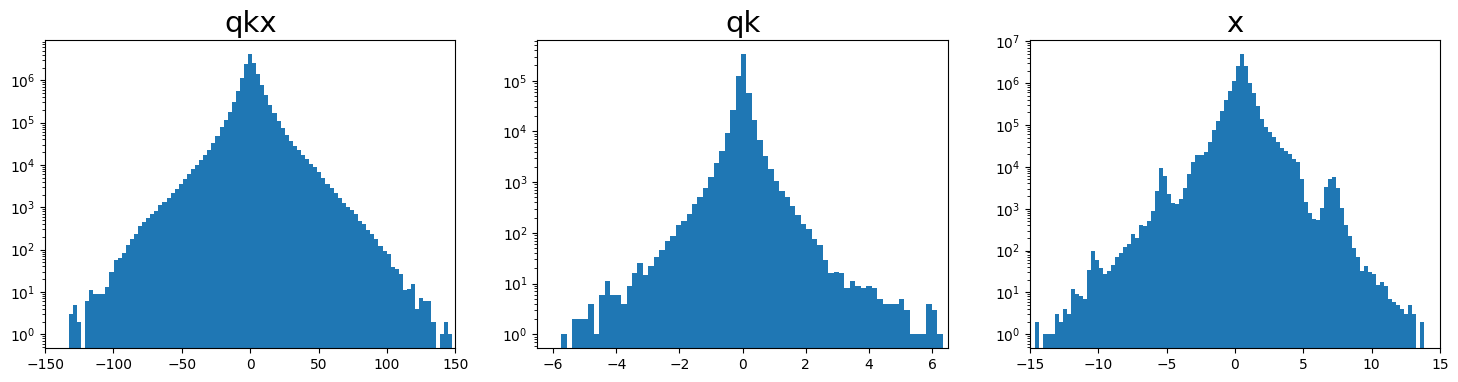

In [20]:
q = q.numpy()
k = k.numpy()
qk = np.matmul(q, k.T)
qkx = np.matmul(qk, np.transpose(x, (0, 2, 1)))

qk = np.reshape(qk, newshape=-1).tolist()
x = np.reshape(x, newshape=-1).tolist()
qkx = np.reshape(qkx, newshape=-1).tolist()

fig, ax = plt.subplots(figsize=(18, 4))

# qkx
plt.subplot(1, 3, 1)
plt.hist(qkx, bins=100)
plt.yscale('log')
plt.xlim(-150, 150)
# plt.ylabel('number', fontdict=21)
plt.title('qkx', fontsize=21)

# qk
plt.subplot(1, 3, 2)
plt.hist(qk, bins=100)
plt.yscale('log')
plt.xlim(-6.5, 6.5)
# plt.ylabel('number', fontdict=21)
plt.title('qk', fontsize=21)

# x
plt.subplot(1, 3, 3)
plt.hist(x, bins=100)
plt.yscale('log')
plt.xlim(-15, 15)
# plt.ylabel('number', fontdict=21)
plt.title('x', fontsize=21)

plt.show()

